# Regression Week 5: LASSO (coordinate descent)

In this notebook, you will implement your very own LASSO solver via coordinate descent. You will:
* Write a function to normalize features
* Implement coordinate descent for LASSO
* Explore effects of L1 penalty

# Fire up graphlab create

Make sure you have the latest version of graphlab (>= 1.7)

In [12]:
import graphlab

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [13]:
sales = graphlab.SFrame('kc_house_data.gl/')
# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to int, before using it below
sales['floors'] = sales['floors'].astype(int) 

If we want to do any "feature engineering" like creating new features or adjusting existing ones we should do this directly using the SFrames as seen in the first notebook of Week 2. For this notebook, however, we will work with the existing features.

# Import useful functions from previous notebook

As in Week 2, we convert the SFrame into a 2D Numpy array. Copy and paste `get_num_data()` from the second notebook of Week 2.

In [14]:
import numpy as np # note this allows us to refer to numpy as np instead 

In [15]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]
    
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]

    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

Also, copy and paste the `predict_output()` function to compute the predictions for an entire matrix of features given the matrix and the weights:

In [16]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)

    return(predictions)

# Normalize features
In the house dataset, features vary wildly in their relative magnitude: `sqft_living` is very large overall compared to `bedrooms`, for instance. As a result, weight for `sqft_living` would be much smaller than weight for `bedrooms`. This is problematic because "small" weights are dropped first as `l1_penalty` goes up. 

To give equal considerations for all features, we need to **normalize features** as discussed in the lectures: we divide each feature by its 2-norm so that the transformed feature has norm 1.

Let's see how we can do this normalization easily with Numpy: let us first consider a small matrix.

In [21]:
X = np.array([[3.,5.,8.],[4.,12.,15.]])
print X

[[  3.   5.   8.]
 [  4.  12.  15.]]


Numpy provides a shorthand for computing 2-norms of each column:

In [22]:
norms = np.linalg.norm(X, axis=0) # gives [norm(X[:,0]), norm(X[:,1]), norm(X[:,2])]
print norms

[  5.  13.  17.]


To normalize, apply element-wise division:

In [23]:
print X / norms # gives [X[:,0]/norm(X[:,0]), X[:,1]/norm(X[:,1]), X[:,2]/norm(X[:,2])]

[[ 0.6         0.38461538  0.47058824]
 [ 0.8         0.92307692  0.88235294]]


Using the shorthand we just covered, write a short function called `normalize_features(feature_matrix)`, which normalizes columns of a given feature matrix. The function should return a pair `(normalized_features, norms)`, where the second item contains the norms of original features. As discussed in the lectures, we will use these norms to normalize the test data in the same way as we normalized the training data. 

In [24]:
def normalize_features(feature_matrix):
    norman = np.linalg.norm(feature_matrix, axis=0)
    return feature_matrix/norman, norman

To test the function, run the following:

In [25]:
features, norms = normalize_features(np.array([[3.,6.,9.],[4.,8.,12.]]))
print features
# should print
# [[ 0.6  0.6  0.6]
#  [ 0.8  0.8  0.8]]
print norms
# should print
# [5.  10.  15.]

[[ 0.6  0.6  0.6]
 [ 0.8  0.8  0.8]]
[  5.  10.  15.]


# Implementing Coordinate Descent with normalized features

We seek to obtain a sparse set of weights by minimizing the LASSO cost function
```
SUM[ (prediction - output)^2 ] + lambda*( |w[1]| + ... + |w[k]|).
```
(By convention, we do not include `w[0]` in the L1 penalty term. We never want to push the intercept to zero.)

The absolute value sign makes the cost function non-differentiable, so simple gradient descent is not viable (you would need to implement a method called subgradient descent). Instead, we will use **coordinate descent**: at each iteration, we will fix all weights but weight `i` and find the value of weight `i` that minimizes the objective. That is, we look for
```
argmin_{w[i]} [ SUM[ (prediction - output)^2 ] + lambda*( |w[1]| + ... + |w[k]|) ]
```
where all weights other than `w[i]` are held to be constant. We will optimize one `w[i]` at a time, circling through the weights multiple times.  
  1. Pick a coordinate `i`
  2. Compute `w[i]` that minimizes the cost function `SUM[ (prediction - output)^2 ] + lambda*( |w[1]| + ... + |w[k]|)`
  3. Repeat Steps 1 and 2 for all coordinates, multiple times

For this notebook, we use **cyclical coordinate descent with normalized features**, where we cycle through coordinates 0 to (d-1) in order, and assume the features were normalized as discussed above. The formula for optimizing each coordinate is as follows:
```
       ┌ (ro[i] + lambda/2)     if ro[i] < -lambda/2
w[i] = ├ 0                      if -lambda/2 <= ro[i] <= lambda/2
       └ (ro[i] - lambda/2)     if ro[i] > lambda/2
```
where
```
ro[i] = SUM[ [feature_i]*(output - prediction + w[i]*[feature_i]) ].
```

Note that we do not regularize the weight of the constant feature (intercept) `w[0]`, so, for this weight, the update is simply:
```
w[0] = ro[i]
```

## Effect of L1 penalty

Let us consider a simple model with 2 features:

In [393]:
simple_features = ['sqft_living', 'bedrooms']
my_output = 'price'
(simple_feature_matrix, simple_features_output) = get_numpy_data(sales, simple_features, my_output)

Don't forget to normalize features:

In [413]:
simple_feature_matrix, norms = normalize_features(simple_feature_matrix)

We assign some random set of initial weights and inspect the values of `ro[i]`:

In [414]:
weights = np.array([1., 4., 1.])

Use `predict_output()` to make predictions on this data.

In [415]:
prediction = predict_output(simple_feature_matrix, weights)

Compute the values of `ro[i]` for each feature in this simple model, using the formula given above, using the formula:
```
ro[i] = SUM[ [feature_i]*(output - prediction + w[i]*[feature_i]) ]
```

*Hint: You can get a Numpy vector for feature_i using:*
```
simple_feature_matrix[:,i]
```

In [416]:
def compute_ro(i, matrix, weights, output):
#     if i != 0:        
        weights_copy = weights.copy()
        weights_copy[i] = 0 #zero out the contribution of curr_weight
        predictions = predict_output(matrix, weights_copy)

        i_vec = matrix[:,i]
        return ((output - predictions) * i_vec).sum()
#     else:
#         predictions = predict_output(matrix, weights)
#         return (output - predictions).sum()

In [417]:
def compute_ro_all_weights(matrix, weights, output):
    ret_val = []
    for i, curr_weight in enumerate(weights):
        print('weights[{}] = {}'.format(i, curr_weight))
        ret_val.append(compute_ro(i, matrix, weights, output))
 
    return ret_val

In [419]:
updated_weights = compute_ro_all_weights(simple_feature_matrix, weights, simple_features_output)
updated_weights

weights[0] = 1.0
weights[1] = 4.0
weights[2] = 1.0


[79400300.034929156, 87939470.772991076, 80966698.675965652]

***QUIZ QUESTION***

Recall that, whenever `ro[i]` falls between `-l1_penalty/2` and `l1_penalty/2`, the corresponding weight `w[i]` is sent to zero. Now suppose we were to take one step of coordinate descent on either feature 1 or feature 2. What range of values of `l1_penalty` **would not** set `w[1]` zero, but **would** set `w[2]` to zero, if we were to take a step in that coordinate? 

In [423]:
# ro[i] > lambda/2
# ro[i] * 2 > lambda
print('w0 = {}, w1 * 2 = {}, w2 * 2 = {}'.format(updated_weights[0], updated_weights[1]*2., updated_weights[2]*2.))

w0 = 79400300.0349, w1 * 2 = 175878941.546, w2 * 2 = 161933397.352


***QUIZ QUESTION***

What range of values of `l1_penalty` would set **both** `w[1]` and `w[2]` to zero, if we were to take a step in that coordinate? 

So we can say that `ro[i]` quantifies the significance of the i-th feature: the larger `ro[i]` is, the more likely it is for the i-th feature to be retained.

## Single Coordinate Descent Step

Using the formula above, implement coordinate descent that minimizes the cost function over a single feature i. Note that the intercept (weight 0) is not regularized. The function should accept feature matrix, output, current weights, l1 penalty, and index of feature to optimize over. The function should return new weight for feature i.

In [424]:
def lasso_coordinate_descent_step(i, feature_matrix, output, weights, l1_penalty):
    # compute prediction
#     prediction = ...
    # compute ro[i] = SUM[ [feature_i]*(output - prediction + weight[i]*[feature_i] ) ]
    ro_i = compute_ro(i, feature_matrix, weights, output)

    l_over_2 = l1_penalty/2.
    if i == 0: # intercept -- do not regularize
        new_weight_i = ro_i 
    elif ro_i < -l_over_2:
        new_weight_i = ro_i + l_over_2
    elif ro_i > l_over_2:
        new_weight_i = ro_i - l_over_2
    else:
        new_weight_i = 0.
    
    return new_weight_i

To test the function, run the following cell:

In [425]:
# should print 0.425558846691
import pandas as pd
import math

print lasso_coordinate_descent_step(1, np.array([[3./math.sqrt(13),1./math.sqrt(10)],[2./math.sqrt(13),3./math.sqrt(10)]]), 
                                   np.array([1., 1.]), np.array([1., 4.]), 0.1)

0.425558846691


## Cyclical coordinate descent 

Now that we have a function that optimizes the cost function over a single coordinate, let us implement cyclical coordinate descent where we optimize coordinates 0, 1, ..., (d-1) in order and repeat.

When do we know to stop? Each time we scan all the coordinates (features) once, we measure the change in weight for each coordinate. If no coordinate changes by more than a specified threshold, we stop.

For each iteration:
1. As you loop over features in order and perform coordinate descent, measure how much each coordinate changes.
2. After the loop, if the maximum change across all coordinates is falls below the tolerance, stop. Otherwise, go back to step 1.

Return weights

**IMPORTANT: when computing a new weight for coordinate i, make sure to incorporate the new weights for coordinates 0, 1, ..., i-1. One good way is to update your weights variable in-place. See following pseudocode for illustration.**
```
for i in range(len(weights)):
    old_weights_i = weights[i] # remember old value of weight[i], as it will be overwritten
    # the following line uses new values for weight[0], weight[1], ..., weight[i-1]
    #     and old values for weight[i], ..., weight[d-1]
    weights[i] = lasso_coordinate_descent_step(i, feature_matrix, output, weights, l1_penalty)
    
    # use old_weights_i to compute change in coordinate
    ...
```

In [426]:
def lasso_cyclical_coordinate_descent(feature_matrix, output, initial_weights, l1_penalty, tolerance):
    weights_list = []

    last_weights = initial_weights.copy()
    iteration = 0
    while True:
        iteration += 1
        max_change = 0
        new_weights = last_weights.copy()
        for i, curr_weight in enumerate(last_weights):
            
            # new weights should be computed using the weights from the last pass
            new_weight = lasso_coordinate_descent_step(i, feature_matrix, output, new_weights, l1_penalty)
            new_weights[i] = new_weight

            weight_diff = abs(new_weight - curr_weight)
            if weight_diff > max_change:
                max_change = weight_diff
                
        last_weights = new_weights
        weights_list.append(new_weights.tolist())
        if max_change < tolerance:
            return last_weights, weights_list
        

Using the following parameters, learn the weights on the sales dataset. 

In [427]:
simple_features = ['sqft_living', 'bedrooms']
my_output = 'price'
initial_weights = np.zeros(3)
l1_penalty = 1e7
tolerance = 1.0

First create a normalized version of the feature matrix, `normalized_simple_feature_matrix`.

In [434]:
(simple_feature_matrix, simple_feature_output) = get_numpy_data(sales, simple_features, my_output)
(normalized_simple_feature_matrix, simple_norms) = normalize_features(simple_feature_matrix) # normalize features

Then, run your implementation of LASSO coordinate descent:

In [437]:
(simple_features_weights, simple_features_weights_list) = lasso_cyclical_coordinate_descent(normalized_simple_feature_matrix, output,
                                            initial_weights, l1_penalty, tolerance)

In [438]:
weights_df = pd.DataFrame(simple_features_weights_list)

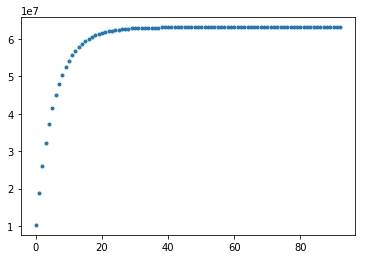

In [439]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(weights_df)), weights_df[1].tolist(), '.')

In [449]:
simple_all_columns = ['intercept'] + simple_features
pd.DataFrame([simple_features_weights.tolist()], columns=simple_all_columns)

,intercept,sqft_living,bedrooms
0,2.162500e+07,6.315725e+07,0.0


In [435]:
def get_residual_sum_of_squares(features, weights, outcome):
    # First get the predictions
    predictions = predict_output(features, weights)
    
    # Then compute the residuals/errors
    residuals = outcome - predictions

    # Then square and add them up
    RSS = (residuals * residuals).sum()

    return(RSS)

In [445]:
from decimal import Decimal

simple_features_rss = get_residual_sum_of_squares(normalized_simple_feature_matrix, simple_features_weights, simple_feature_output)
print '{:.2E}'.format(simple_features_rss)

1.63E+15


***QUIZ QUESTIONS***
1. What is the RSS of the learned model on the normalized dataset? (Hint: use the normalized feature matrix when you make predictions.)
2. Which features had weight zero at convergence?

# Evaluating LASSO fit with more features

Let us split the sales dataset into training and test sets.

In [317]:
train_data,test_data = sales.random_split(.8,seed=0)

Let us consider the following set of features.

In [351]:
all_features = ['bedrooms',
                'bathrooms',
                'sqft_living',
                'sqft_lot',
                'floors',
                'waterfront', 
                'view', 
                'condition', 
                'grade',
                'sqft_above',
                'sqft_basement',
                'yr_built', 
                'yr_renovated']
all_columns = ['intercept'] + all_features

First, create a normalized feature matrix from the TRAINING data with these features.  (Make you store the norms for the normalization, since we'll use them later)

In [362]:
(big_feature_matrix, output) = get_numpy_data(train_data, all_features, my_output)
normalized_big_feature_matrix, normalized_big_feature_norms = normalize_features(big_feature_matrix)

First, learn the weights with `l1_penalty=1e7`, on the training data. Initialize weights to all zeros, and set the `tolerance=1`.  Call resulting weights `weights1e7`, you will need them later.

In [371]:
(weights1e7, norm_weights_list) = lasso_cyclical_coordinate_descent(normalized_big_feature_matrix, output, np.zeros(14), 1e7, 1.0)
norm_weights1e7 = weights1e7 / normalized_big_feature_norms
pd.DataFrame([weights1e7.tolist()], columns=all_columns)

,intercept,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
0,2.442960e+07,0.0,0.0,4.838917e+07,0.0,0.0,3.317511e+06,7.329962e+06,0.0,0.0,0.0,0.0,0.0,0.0


In [372]:
pd.DataFrame([norm_weights1e7.tolist()], columns=all_columns)

,intercept,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
0,185285.532617,0.0,0.0,161.317456,0.0,0.0,287664.70032,69193.705706,0.0,0.0,0.0,0.0,0.0,0.0


***QUIZ QUESTION***

What features had non-zero weight in this case?

Next, learn the weights with `l1_penalty=1e8`, on the training data. Initialize weights to all zeros, and set the `tolerance=1`.  Call resulting weights `weights1e8`, you will need them later.

In [373]:
(weights1e8, norm_weights_list) = lasso_cyclical_coordinate_descent(normalized_big_feature_matrix, output, np.zeros(14), 1e8, 1.0)
norm_weights1e8 = weights1e8 / normalized_big_feature_norms
pd.DataFrame([weights1e8.tolist()], columns=all_columns)

,intercept,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
0,7.111463e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [374]:
pd.DataFrame([norm_weights1e8.tolist()], columns=all_columns)

,intercept,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
0,539366.628221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***QUIZ QUESTION***

What features had non-zero weight in this case?

Finally, learn the weights with `l1_penalty=1e4`, on the training data. Initialize weights to all zeros, and set the `tolerance=5e5`.  Call resulting weights `weights1e4`, you will need them later.  (This case will take quite a bit longer to converge than the others above.)

In [375]:
(weights1e4, norm_weights_list) = lasso_cyclical_coordinate_descent(normalized_big_feature_matrix, output,np.zeros(14), 1e4, 5e5)
norm_weights1e4 = weights1e4 / normalized_big_feature_norms
pd.DataFrame([weights1e4.tolist()], columns=all_columns)

,intercept,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
0,7.777907e+07,-2.288401e+07,1.534849e+07,9.216687e+07,-2.139328e+06,-8.818456e+06,6.494210e+06,7.065162e+06,4.119079e+06,1.843648e+07,-1.456668e+07,-5.528349e+06,-8.359175e+07,2.784276e+06


In [376]:
pd.DataFrame([norm_weights1e4.tolist()], columns=all_columns)

,intercept,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
0,589912.924358,-49743.503878,51704.424994,307.26139,-0.367766,-43204.889334,563119.400376,66694.035344,8997.677153,18056.934201,-56.084689,-78.838449,-321.603081,51.853181


***QUIZ QUESTION***

What features had non-zero weight in this case?

## Rescaling learned weights

Recall that we normalized our feature matrix, before learning the weights.  To use these weights on a test set, we must normalize the test data in the same way.

Alternatively, we can rescale the learned weights to include the normalization, so we never have to worry about normalizing the test data: 

In this case, we must scale the resulting weights so that we can make predictions with *original* features:
 1. Store the norms of the original features to a vector called `norms`:
```
features, norms = normalize_features(features)
```
 2. Run Lasso on the normalized features and obtain a `weights` vector
 3. Compute the weights for the original features by performing element-wise division, i.e.
```
weights_normalized = weights / norms
```
Now, we can apply `weights_normalized` to the test data, without normalizing it!

Create a normalized version of each of the weights learned above. (`weights1e4`, `weights1e7`, `weights1e8`).

In [377]:
norm_weights1e7[3]

161.31745624837859

To check your results, if you call `normalized_weights1e7` the normalized version of `weights1e7`, then:
```
print normalized_weights1e7[3]
```
should return 161.31745624837794.

## Evaluating each of the learned models on the test data

Let's now evaluate the three models on the test data:

In [379]:
(test_feature_matrix, test_output) = get_numpy_data(test_data, all_features, 'price')

Compute the RSS of each of the three normalized weights on the (unnormalized) `test_feature_matrix`:

In [451]:
'{:.2E}'.format(get_residual_sum_of_squares(test_feature_matrix, norm_weights1e7, test_output))

'2.76E+14'

In [452]:
'{:.2E}'.format(get_residual_sum_of_squares(test_feature_matrix, norm_weights1e8, test_output))

'5.37E+14'

In [453]:
'{:.2E}'.format(get_residual_sum_of_squares(test_feature_matrix, norm_weights1e4, test_output))

'2.28E+14'

***QUIZ QUESTION***

Which model performed best on the test data?